## Installing `open3d`

In [1]:
!pip install open3d > q

## Importing libraries

In [2]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import torch
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
import open3d as o3d
from dataclasses import dataclass

2026-01-06 17:08:11.266024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767719291.433713      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767719291.483327      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1767719291.896689      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767719291.896732      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1767719291.896735      55 computation_placer.cc:177] computation placer alr

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Setting up the configuration

In [3]:
@dataclass
class CONFIG:
    IMAGE = "/kaggle/input/3d-reconstruction/bird1.jpg"
    PRETRAINED_GLPN = "vinvino02/glpn-nyu"

## Loading the depth estimator

In [4]:
def load_depth_estimator_feature_extractor_and_model(glpn):
    depth_estimator_feature_extractor = GLPNImageProcessor.from_pretrained(glpn)
    depth_estimator_model = GLPNForDepthEstimation.from_pretrained(glpn)

    return depth_estimator_feature_extractor, depth_estimator_model

## Preprocess image

In [5]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    modified_image_height = 480 if image.height > 480 else image.height
    modified_image_height -= (modified_image_height % 32)
    modified_image_width = int(modified_image_height * image.width / image.height)
    difference = modified_image_width % 32
    
    modified_image_width = modified_image_width - difference if difference < 16 else modified_image_width + 32 - difference
    update_image_size = (modified_image_width, modified_image_height)
    image = image.resize(update_image_size)

    return image

## Run depth estimation model

In [6]:
def run_depth_estimation_model(feature_extractor, model, image):
    inputs_for_depth_estimator = feature_extractor(images=image, return_tensors="pt")
    
    with torch.no_grad():
        outputs = model(**inputs_for_depth_estimator)
        predicted_depth = outputs.predicted_depth

    return predicted_depth

# Visualizing depth estimation results

In [7]:
def visualize_depth_estimation_results(image, predicted_depth):
    padding_amount = 16
    output = predicted_depth.squeeze().cpu().numpy() * 1000.0
    output = output[padding_amount: -padding_amount, padding_amount: - padding_amount]
    image = image.crop((padding_amount, padding_amount, image.width - padding_amount, image.height - padding_amount))
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image)
    ax[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax[1].imshow(output, cmap="plasma")
    ax[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.tight_layout()
    plt.pause(5)

    return output, image

## Convert predicted depth map and RGB image into RGBD Open3D representation

In [8]:
def get_rgdb_and_camera_intrinsic(output, image):
    width, height = image.size
    
    image_depth = (output * 255 / np.max(output)).astype("uint8")
    image = np.array(image)
    
    depth_o3d = o3d.geometry.Image(image_depth)
    image_o3d = o3d.geometry.Image(image)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        image_o3d,
        depth_o3d,
        convert_rgb_to_intensity=False
    )
    
    pinhole_camera_instrinsic = o3d.camera.PinholeCameraIntrinsic()
    pinhole_camera_instrinsic.set_intrinsics(width, height, 500, 500, width / 2, height / 2)

    return rgbd_image, pinhole_camera_instrinsic

## Save the point clouds and meshes

In [9]:
def save_ply_files(image_name, rgbd_image, camera_instrinsic):
    image_name_for_saving = image_name.split("/")[-1]
        
    pcd_raw = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        camera_instrinsic
    )
    o3d.io.write_point_cloud(f"pcd_raw_{image_name_for_saving}.ply", pcd_raw)
    print(f"Saved PCD raw for {image_name_for_saving}")

    _, indices_returned = pcd_raw.remove_statistical_outlier(nb_neighbors=20, std_ratio=20.0)
    pcd = pcd_raw.select_by_index(indices_returned)
    
    pcd.estimate_normals()
    pcd.orient_normals_to_align_with_direction()
    
    o3d.io.write_point_cloud(f"pcd_post_processing_3d_point_cloud_{image_name_for_saving}.ply", pcd)
    print(f"Saved PCD post preprocessing for {image_name_for_saving}")

    mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd,
        depth=10,
        n_threads=1
    )[0]
    
    rotation = mesh.get_rotation_matrix_from_xyz((np.pi, 0, 0))
    mesh.rotate(rotation, center=(0, 0, 0))
    
    o3d.io.write_triangle_mesh(f"mesh_{image_name_for_saving}.ply", mesh)

    print(f"Saved mesh for {image_name_for_saving}")

## Execute all the functions and save the results

preprocessor_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/245M [00:00<?, ?B/s]

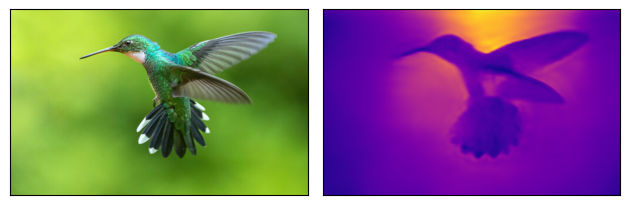

Saved PCD raw for bird1.jpg
Saved PCD post preprocessing for bird1.jpg
[Open3D WARNING] Write Ply clamped color value to valid range
Saved mesh for bird1.jpg


In [10]:
def run_all(glpn, image_path):
    feature_extractor, model = load_depth_estimator_feature_extractor_and_model(glpn)
    image = preprocess_image(image_path)
    predicted_depth = run_depth_estimation_model(feature_extractor, model, image)
    output, image = visualize_depth_estimation_results(image, predicted_depth)
    rgbd_image, camera_instrinsic = get_rgdb_and_camera_intrinsic(output, image)
    save_ply_files(CONFIG.IMAGE, rgbd_image, camera_instrinsic)

run_all(glpn=CONFIG.PRETRAINED_GLPN, image_path=CONFIG.IMAGE)